In [1]:
import ctypes
from PIL import Image
import qahirah

pangocairo = ctypes.CDLL(ctypes.util.find_library('pangocairo-1.0'))
pango = ctypes.CDLL(ctypes.util.find_library('pango-1.0'))
gobject = ctypes.CDLL(ctypes.util.find_library('gobject-2.0'))


In [2]:
# from  https://github.com/mittagessen/kraken/blob/master/kraken/linegen.py

#class PangoFontDescription(ctypes.Structure):
#    pass

class PangoLayout(ctypes.Structure):
    pass

#class PangoContext(ctypes.Structure):
#    pass

#class PangoRectangle(ctypes.Structure):
#    _fields_ = [('x', ctypes.c_int), 
#                ('y', ctypes.c_int), 
#                ('width', ctypes.c_int), 
#                ('height', ctypes.c_int)]


# pangocairo.pango_cairo_create_context.restype = ctypes.POINTER(PangoContext)
pangocairo.pango_cairo_create_layout.restype = ctypes.POINTER(PangoLayout)

#pango.pango_layout_new.restype = ctypes.POINTER(PangoLayout)
#pango.pango_font_description_new.restype = ctypes.POINTER(PangoFontDescription)
#pango.pango_font_description_set_family.argtypes = [ctypes.POINTER(PangoFontDescription), ctypes.c_char_p]
pango.pango_layout_set_markup.argtypes = [ctypes.POINTER(PangoLayout), ctypes.c_char_p, ctypes.c_int]


In [3]:
def get_data_view(im):
    size = im.height * im.stride
    ArrayType = ctypes.c_char * size
    return ctypes.cast(im.data, ctypes.POINTER(ArrayType)).contents
    
def to_pil(im):
    data = get_data_view(im)
    
    im.flush()
    
    if im.format == qahirah.CAIRO.FORMAT_ARGB32:
        return Image.frombuffer("RGBA", (im.width, im.height), data, "raw", "BGRa", im.stride, 1)
    else:
        raise ValueError("Unknown format: {!r}".format(im.format))

In [4]:
def draw_pango_markup(self, markup, width=None):
    ctx = self._cairobj
    layout = pangocairo.pango_cairo_create_layout(ctx)
    try:
        if width is not None:
            pango.pango_layout_set_width(layout, width * 1024)
        pango.pango_layout_set_markup(layout, markup, -1)
        pangocairo.pango_cairo_show_layout(ctx, layout)
    finally:
        gobject.g_object_unref(layout)

    return self

qahirah.Context.draw_pango_markup = draw_pango_markup

del draw_pango_markup

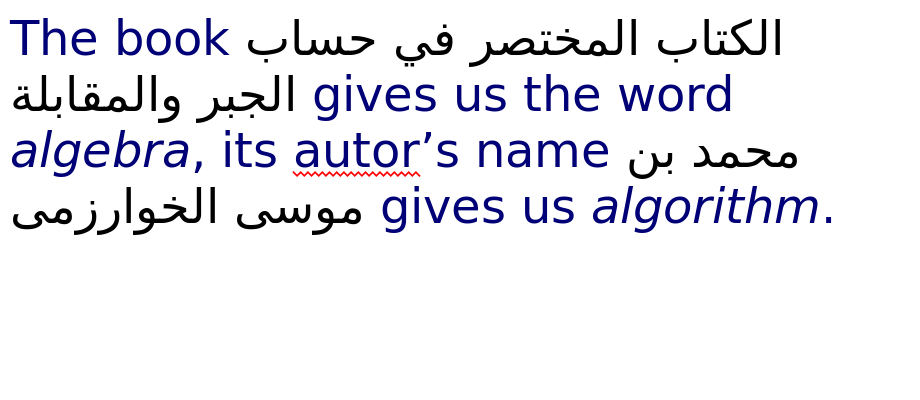

In [5]:
import qahirah

WIDTH = 900
MARGIN = 10

im = qahirah.ImageSurface.create(qahirah.CAIRO.FORMAT_ARGB32, dimensions=(WIDTH + 2 * MARGIN, 400))
ctx = qahirah.Context.create(im)
#ctx.set_source_colour(qahirah.Colour(r=1,g=1,b=1,a=1))
#ctx.paint()

book_title = \
    (
        "\u0627\u0644\u0643\u062a\u0627\u0628" # “al-kitab”
        " \u0627\u0644\u0645\u062e\u062a\u0635\u0631" # “al-mukhtasar”
        " \u0641\u064a" # “fi”
        " \u062d\u0633\u0627\u0628" # “hisab”
        " \u0627\u0644\u062c\u0628\u0631" # “al-jabr”
        " \u0648\u0627\u0644\u0645\u0642\u0627\u0628\u0644\u0629" # “wa’l-muqabala”
    )
author = \
    (
        "\u0645\u062d\u0645\u062f" # “Muhammad’
        " \u0628\u0646" # “ibn”
        " \u0645\u0648\u0633\u0649" # “Musa”
        " \u0627\u0644\u062e\u0648\u0627\u0631\u0632\u0645\u06cc" # “al-Khwarizmi”
    )
text_line = \
    (
        "The book <span color='black'>%(title)s</span> gives us the word <i>algebra</i>,"
        " its <span underline='error' underline-color='red'>autor</span>’s name"
        " <span color='black'>%(author)s</span> gives us <i>algorithm</i>."
    %
        {"author" : author, "title" : book_title}
    )

text_line = text_line
markup = ("<span color='#007' font='DejaVu Sans, 36'>%s</span>" % text_line).encode('utf8')    
# ctx.rotate(.1)
ctx.move_to((MARGIN, MARGIN)).draw_pango_markup(markup, width=WIDTH)

to_pil(im)